<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#TextCNN" data-toc-modified-id="TextCNN-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>TextCNN</a></span><ul class="toc-item"><li><span><a href="#notes:" data-toc-modified-id="notes:-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>notes:</a></span></li></ul></li><li><span><a href="#LSTM" data-toc-modified-id="LSTM-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>LSTM</a></span></li></ul></div>

In [56]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/Text-Classification/code")
!pip install pyLDAvis
!pip install gensim
!pip install pandas==1.3.0
import nltk
nltk.download('punkt')
nltk.download('stopwords')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [57]:
import numpy as np 
from sklearn import metrics
from clustering_utils import *
from eda_utils import *
from nn_utils_keras import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

####################################
### string normalized
####################################


from gensim.utils import tokenize
from nltk.tokenize import word_tokenize
from gensim.parsing.preprocessing import remove_stopwords

def normal_string(x):
    x = remove_stopwords(x)
#     x = " ".join(preprocess_string(x))
    x = " ".join(word_tokenize(x, preserve_line=False)).strip()
    return x


In [58]:
train, test = load_data()
train, upsampling_info = upsampling_train(train)

train_text, train_label = train_augmentation(train, select_comb=None)
test_text, test_label = test['text'], test['label']

# test_text = test_text.apply(lambda x: normal_string(x))
# train_text = train_text.apply(lambda x: normal_string(x))


may use cols: 
 ['global_index', 'doc_path', 'label', 'reply', 'reference_one', 'reference_two', 'tag_reply', 'tag_reference_one', 'tag_reference_two', 'Subject', 'From', 'Lines', 'Organization', 'contained_emails', 'long_string', 'text', 'error_message']


In [59]:
####################################
### label mapper
####################################
labels = sorted(train_label.unique())
label_mapper = dict(zip(labels, range(len(labels))))
train_label = train_label.map(label_mapper)
test_label = test_label.map(label_mapper)
y_train = train_label
y_test = test_label

print(train_text.shape)
print(test_text.shape)
print(train_label.shape)
print(test_label.shape)
print(labels)

(11813,)
(7761,)
(11813,)
(7761,)
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


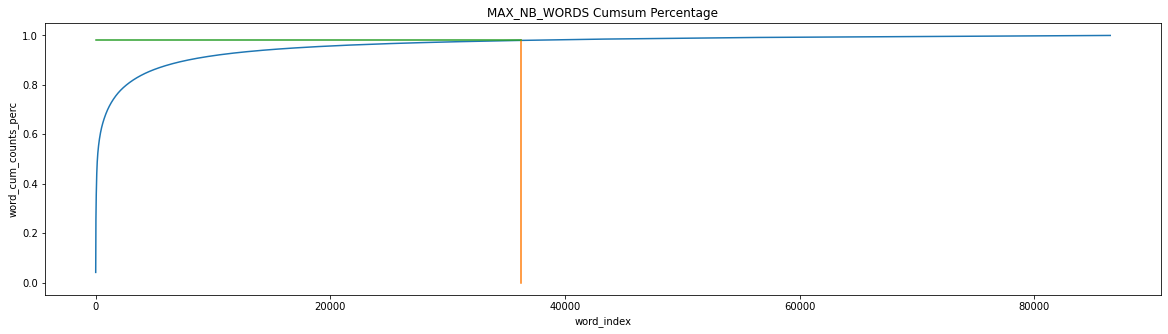

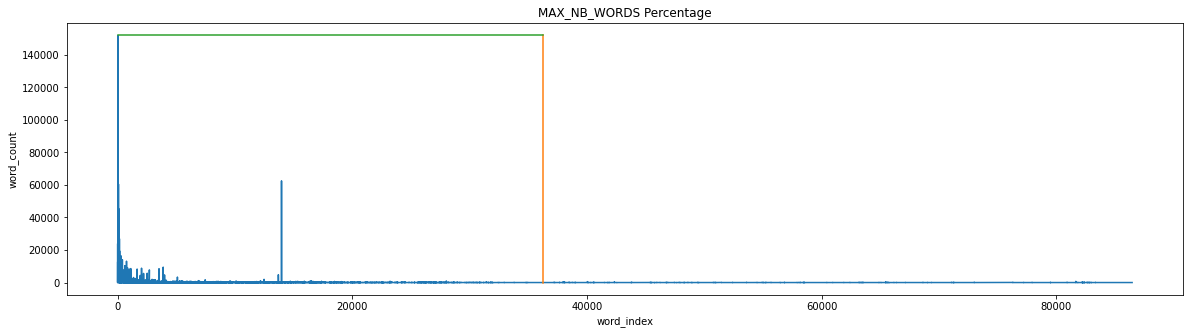

Cut index with 98.0 % of corpus:  36272 

    index  word   count
0      44   the  151949
1      33    to   78198
2      17    of   71974
3      56     a   70559
4   13970    ax   62523
5      75   and   60503
6      49     i   57650
7      31    in   51376
8      84    is   45574
9     137  that   41790
10     83    it   35238
11     53   for   29632
12     39   you   28486
13    156     s   26922
14    163     t   24875
15      0  from   23454
16      8   edu   22214
17    139    on   21270
18     63  this   21065
19     86    be   19868


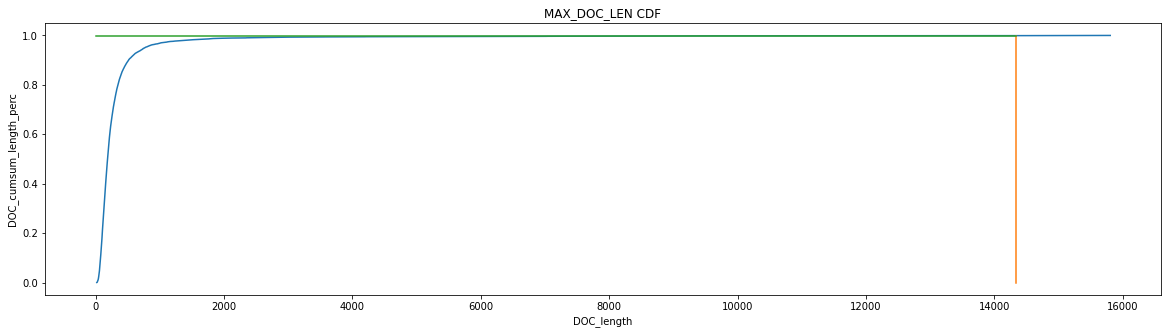

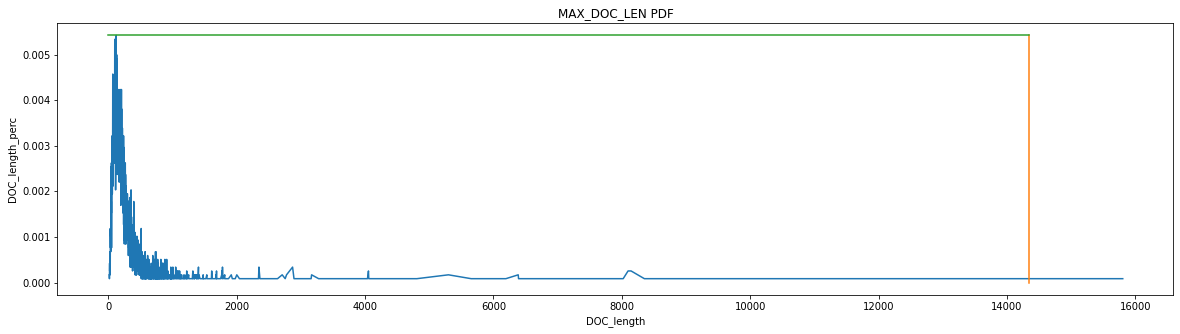

Cut index with 99.9 % of corpus:  14339


In [60]:

####################################
### hyper params 
####################################
filters = '"#$%&()*+,-/:;<=>@[\\]^_`{|}~\t\n0123465789!.?\''
MAX_NB_WORDS_ratio = 0.98
MAX_DOC_LEN_ratio = 0.999
MAX_NB_WORDS = eda_MAX_NB_WORDS(train_text, ratio=MAX_NB_WORDS_ratio, char_level=False, filters=filters)
MAX_DOC_LEN = eda_MAX_DOC_LEN(train_text, ratio=MAX_DOC_LEN_ratio, char_level=False, filters=filters)

In [61]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Embedding, Dense, Conv1D, MaxPooling1D, Dropout, Activation, Input, Flatten, Concatenate, Lambda
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow import keras
import numpy as np
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

# TextCNN

## notes:

In [62]:
####################################
### train val test split
####################################
x_train_val, y_train_val, x_test, y_test = train_text, train_label, test_text, test_label
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.2, stratify=y_train_val)

####################################
### preprocessor for NN input
####################################
processor = text_preprocessor(MAX_DOC_LEN, MAX_NB_WORDS, train_text, filters='"#$%&()*+,-/:;<=>@[\\]^_`{|}~\t\n0123465789')
x_train = processor.generate_seq(x_train)
x_val = processor.generate_seq(x_val)
x_test = processor.generate_seq(x_test)
# y_train = to_categorical(y_train)
# y_val = to_categorical(y_val)
# y_test = to_categorical(y_test)


print('Shape of x_tr: ' + str(x_train.shape))
print('Shape of y_tr: ' + str(y_train.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_test: ' + str(y_test.shape))


info = pd.concat([y_train.value_counts(), y_val.value_counts(), y_val.value_counts()/y_train.value_counts(), y_train.value_counts()/y_train.size\
                 , y_test.value_counts(), y_test.value_counts()/y_test.size], axis=1)
info.index = labels
info.columns = ['tr_size', 'val_size', 'val_ratio', 'tr_prop', 'test_size', 'test_prop']
info

Shape of x_tr: (9450, 14339)
Shape of y_tr: (9450,)
Shape of x_val: (2363, 14339)
Shape of y_val: (2363,)
Shape of x_test: (7761, 14339)
Shape of y_test: (7761,)


,tr_size,val_size,val_ratio,tr_prop,test_size,test_prop
alt.atheism,443,111,0.250564,0.046878,319,0.041103
comp.graphics,467,117,0.250535,0.049418,389,0.050122
comp.os.ms-windows.misc,473,118,0.249471,0.050053,394,0.050767
comp.sys.ibm.pc.hardware,472,118,0.250000,0.049947,392,0.050509
comp.sys.mac.hardware,463,115,0.248380,0.048995,385,0.049607
comp.windows.x,474,119,0.251055,0.050159,395,0.050896
misc.forsale,468,117,0.250000,0.049524,390,0.050251
rec.autos,474,119,0.251055,0.050159,395,0.050896
rec.motorcycles,478,120,0.251046,0.050582,398,0.051282
rec.sport.baseball,478,119,0.248954,0.050582,397,0.051153


In [63]:
# define Model for classification

def model_Create(FS, NF, EMB, MDL, MNW, PWV=None, optimizer='RMSprop', trainable_switch=True):
    cnn_box = cnn_model_l2(FILTER_SIZES=FS, MAX_NB_WORDS=MNW, MAX_DOC_LEN=MDL, EMBEDDING_DIM=EMB,
                        NUM_FILTERS=NF, PRETRAINED_WORD_VECTOR=PWV, trainable_switch=trainable_switch)
    # Hyperparameters: MAX_DOC_LEN
    q1_input = Input(shape=(MDL,), name='q1_input')
    encode_input1 = cnn_box(q1_input)
    # half_features = int(len(FS)*NF/2)*10
    x = Dense(384, activation='relu', name='half_features')(encode_input1)
    x = Dropout(rate=0.3, name='dropout1')(x)
#     x = Dense(256, activation='relu', name='dense1')(x)
#     x = Dropout(rate=0.3, name='dropou2')(x)
    x = Dense(128, activation='relu', name='dense2')(x)
    x = Dropout(rate=0.3, name='dropout3')(x)
    x = Dense(64, activation='relu', name='dense3')(x)
    x = Dropout(rate=0.3, name='dropout4')(x)
    pred = Dense(len(labels), activation='softmax', name='Prediction')(x)
    model = Model(inputs=q1_input, outputs=pred)
    model.compile(optimizer=optimizer,
                  loss=keras.losses.SparseCategoricalCrossentropy(),
                  metrics=[keras.metrics.SparseCategoricalAccuracy()])
    return model


EMBEDDING_DIM = 200
# W2V =  processor.w2v_pretrain(EMBEDDING_DIM, min_count=2, seed=1, cbow_mean=1,negative=5, window=20, workers=7) # pretrain w2v by gensim
# W2V = processor.load_glove_w2v(EMBEDDING_DIM) # download glove
W2V = None
trainable_switch = True

In [64]:
# Set hyper parameters
FILTER_SIZES = [2, 4,6,8]
NUM_FILTERS = 64

# OPT = optimizers.Adam(learning_rate=0.005)
OPT = optimizers.RMSprop(learning_rate=0.0005) # 'RMSprop'
PWV = W2V
model = model_Create(FS=FILTER_SIZES, NF=NUM_FILTERS, EMB=EMBEDDING_DIM,
                     MDL=MAX_DOC_LEN, MNW=MAX_NB_WORDS+1, PWV=PWV, 
                     optimizer=OPT, trainable_switch=trainable_switch)

In [65]:
# visual_textCNN(model)

In [ ]:
BATCH_SIZE = 32 # 先在小的batch上train, 容易找到全局最优部分, 然后再到 大 batch 上train, 快速收敛到局部最优
NUM_EPOCHES = 50  # 20步以上
patience = 30

file_name = 'test'
BestModel_Name = file_name + 'Best_GS_3'
BEST_MODEL_FILEPATH = BestModel_Name
# model.load_weights(BestModel_Name) # 这样就能接着上次train

earlyStopping = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=patience, verbose=1, mode='max') # patience: number of epochs with no improvement on monitor : val_loss
checkpoint = ModelCheckpoint(BEST_MODEL_FILEPATH, monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
# history = model.fit(x_train, y_train, validation_data=(x_test,y_test), batch_size=BATCH_SIZE, epochs=NUM_EPOCHES, callbacks=[earlyStopping, checkpoint], verbose=1)
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=BATCH_SIZE, epochs=NUM_EPOCHES, callbacks=[earlyStopping, checkpoint], verbose=1)
model.load_weights(BestModel_Name)

Epoch 1/50
296/296 [==============================] - ETA: 0s - loss: 2.9597 - sparse_categorical_accuracy: 0.0646
Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.10707, saving model to testBest_GS_3
INFO:tensorflow:Assets written to: testBest_GS_3/assets
296/296 [==============================] - 78s 256ms/step - loss: 2.9597 - sparse_categorical_accuracy: 0.0646 - val_loss: 2.7195 - val_sparse_categorical_accuracy: 0.1071
Epoch 2/50
296/296 [==============================] - ETA: 0s - loss: 2.5357 - sparse_categorical_accuracy: 0.1243
Epoch 00002: val_sparse_categorical_accuracy improved from 0.10707 to 0.16251, saving model to testBest_GS_3
INFO:tensorflow:Assets written to: testBest_GS_3/assets
296/296 [==============================] - 75s 253ms/step - loss: 2.5357 - sparse_categorical_accuracy: 0.1243 - val_loss: 2.4187 - val_sparse_categorical_accuracy: 0.1625
Epoch 3/50
296/296 [==============================] - ETA: 0s - loss: 2.1652 - sparse_categorical_a

In [ ]:
#### classification Report
history_plot(history)
y_pred = model.predict(x_test)
# print(classification_report(y_test, np.argmax(y_pred, axis=1)))
print(classification_report(test_label, np.argmax(y_pred, axis=1), target_names=labels))
scores = model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print( "\n\n\n")

In [ ]:
test_label

In [ ]:
#### classification Report
history_plot(history)
y_pred = model.predict(x_test)
# print(classification_report(y_test, np.argmax(y_pred, axis=1)))
print(classification_report(test_label, np.argmax(y_pred, axis=1), target_names=labels))
scores = model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print( "\n\n\n")

# LSTM

In [ ]:
# from tensorflow.keras.layers import SpatialDropout1D, GlobalMaxPooling1D, GlobalMaxPooling2D

# def model_Create(FS, NF, EMB, MDL, MNW, PWV = None, optimizer='RMSprop', trainable_switch=True):
#     model = Sequential()
#     model.add(Embedding(input_dim=MNW, output_dim=EMB, embeddings_initializer='uniform', mask_zero=True, input_length=MDL))
#     model.add(Flatten())   
# #     model.add(GlobalMaxPooling2D()) # downsampling
# #     model.add(SpatialDropout1D(0.2))    
#     model.add(Dense(1024, activation='relu'))   
#     model.add(Dense(512, activation='relu'))   
#     model.add(Dense(128, activation='relu'))   
#     model.add(Dense(64, activation='relu'))   
#     # model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
#     model.add(Dense(20, activation='softmax'))   
#     model.compile(optimizer=optimizer,
#           loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
#           metrics=[keras.metrics.SparseCategoricalAccuracy()])
#     return model

# model = model_Create(FS=FILTER_SIZES, NF=NUM_FILTERS, EMB=EMBEDDING_DIM,
#                      MDL=MAX_DOC_LEN, MNW=MAX_NB_WORDS+1, PWV=PWV, trainable_switch=trainable_switch)

In [ ]:
# visual_textCNN(model)

In [ ]:
# EMBEDDING_DIM = 200
# # W2V =  processor.w2v_pretrain(EMBEDDING_DIM, min_count=2, seed=1, cbow_mean=1,negative=5, window=20, workers=7) # pretrain w2v by gensim
# # W2V = processor.load_glove_w2v(EMBEDDING_DIM) # download glove
# trainable_switch = True
# W2V = None

In [ ]:
# BATCH_SIZE = 64
# NUM_EPOCHES = 10  # patience=20
# patience = 30

# BestModel_Name = 'text_CNN.h5'
# BEST_MODEL_FILEPATH = BestModel_Name

# earlyStopping = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=patience, verbose=1, mode='max') # patience: number of epochs with no improvement on monitor : val_loss
# checkpoint = ModelCheckpoint(BEST_MODEL_FILEPATH, monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
# history = model.fit(x_train, y_train, validation_split=0.2, batch_size=BATCH_SIZE, epochs=NUM_EPOCHES, callbacks=[earlyStopping, checkpoint], verbose=1)
# model.load_weights(BestModel_Name)

In [ ]:
# #### classification Report
# history_plot(history)
# y_pred = model.predict(x_test)
# # print(classification_report(y_test, np.argmax(y_pred, axis=1)))
# print(classification_report(test_label, np.argmax(y_pred, axis=1), target_names=labels))
# scores = model.evaluate(x_test, y_test, verbose=2)
# print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
# print( "\n\n\n")